In [2]:
import requests
from zipfile import ZipFile
from urllib.request import urlretrieve
from boto3.session import Session
import boto3
import io
import os
from io import StringIO
import botocore
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
import pytz
import os
import pyodbc
import struct
import matplotlib.pyplot as plt
import scipy.stats as stats
from functools import reduce
from dotenv import load_dotenv
from functools import reduce
load_dotenv()
pd.options.mode.chained_assignment = None

In [3]:
def graph(df,close):
    if close:
        df.plot(y = 'Close', kind='line',use_index=True,figsize=(40,20), fontsize=20)
    else:
        df.plot(kind='line',use_index=True,figsize=(40,20), fontsize=20)
    plt.grid()
    plt.show()
    plt.close()

In [4]:
def get_s3_object(bucket,folder,fileName):
    s3 = boto3.client('s3')
    key = folder+fileName
    obj = s3.get_object(Bucket=bucket, Key=key)
    df = pd.read_csv(obj['Body'],index_col=0)
    df = df.reset_index()
    datetime = df['Date'].str.split(" ", expand = True)
    df['Date'] = datetime[0]
    df['Time'] = datetime[1]
    df['Offset'] = datetime[2]
    df = df[df['Time'] != '17:00:00']
    df = df.reset_index(drop=True)
    return df

In [5]:
def get_formatted_future(bucket,folder,fileName):
    s3 = boto3.client('s3')
    key = folder+fileName
    obj = s3.get_object(Bucket=bucket, Key=key)
    df = pd.read_csv(obj['Body'],names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize('US/Eastern')
    df.index = df.index.strftime('%Y-%m-%d %H:%M:%S %z').str[:-2] + ':00'
    df['Engine'] = None
    df['Source'] = 'FirstRateData'
    df['Update'] = get_pst_time()
    return df

In [6]:
def check(bucket, folder,fileName):
    s3 = boto3.resource('s3')
    try:
        s3.Object(bucket, folder+fileName).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            # The object does not exist.
            return False
        else:
            # Something else has gone wrong.
            raise
    else:
        return True

In [7]:
code_dict = {
    'A6': 'AD', 'AD': 'CD','B6': 'BP', 'BTP': 'IK','BZ': 'BZA',
    'CA': 'CC','DY': 'GX','E1': 'SF','E6': 'EC','EW': 'FA',
    'FX': 'VG','GF': 'FC','GG': 'RX','HE': 'LH','HR': 'OE',
    'J1': 'JY','LBS': 'LB','LE': 'LC','MES': 'HWA','MME': 'MES',
    'MNQ': 'HWB','MP': 'ME','MX': 'CF','N6': 'NV','RB': 'XB',
    'TN': 'ZT','VX': 'UX','YM': 'DM','ZC': 'C','ZF': 'TU',
    'ZL': 'BO','ZM': 'SM','ZN': 'TY','ZO': 'O','ZQ': 'FF',
    'ZR': 'RR','ZS': 'S','ZT': 'TU','ZW': 'W',
}

In [8]:
def get_pst_time():
    date_format='%Y-%m-%d %H:%M:%S %z'
    date = datetime.now(tz=pytz.utc)
    date = date.astimezone(timezone('US/Pacific'))
    pstDateTime=date.strftime(date_format)
    pstDateTime = "{0}:{1}".format(pstDateTime[:-2],pstDateTime[-2:])
    return pstDateTime

In [9]:
def format_futures(filename):
    df = pd.read_csv(filename, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize('US/Eastern')
    df.index = df.index.strftime('%Y-%m-%d %H:%M:%S %z').str[:-2] + ':00'
    df['Engine'] = None
    df['Source'] = 'FirstRateData'
    df['Update'] = get_pst_time()
    return df

In [10]:
def save_s3_object(bucket,folder,filename,datafrane):
    csv_buffer = StringIO()
    datafrane.to_csv(csv_buffer, sep=",", index=True)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, folder+filename).put(Body=csv_buffer.getvalue())   
    print(f'Saved S3 Object: {bucket}:{folder}{filename}')

In [12]:
server = 'prod2.db.liminalcap.com'
database = 'LCData'
username = 'etay'
password = os.environ.get('PASSWORD')
cnxn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [13]:
bucket = 'lc-eldontest'
prefix = 'one_min/'
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket)

for obj in my_bucket.objects.filter(Prefix=prefix):
    filename = obj.key.split('/')[1]
    #df = get_formatted_future(bucket, prefix, filename)
    
    code = filename.split('_')[0]
    code_format = code_dict.get(code, code)
    print(f'{code} : {code_format}')
    cursor.execute("SELECT [MinuteRecordId] FROM dbo.FuturesStubs WHERE BBSymbol = ? AND TTSymbol IS NOT NULL", code_format)
    for row in cursor.fetchall():
        cursor.execute("SELECT [S3BucketName], [S3PathName], [S3FileName] FROM dbo.DataRecords WHERE Id = ?", row[0])
        for row_nest in cursor.fetchall():
            if cursor.rowcount != 0:
                df = get_formatted_future(bucket, prefix, filename)
                save_s3_object(row_nest[0], row_nest[1], 'FRD_'+row_nest[2], df)
    
          

NoSuchBucket: An error occurred (NoSuchBucket) when calling the ListObjects operation: The specified bucket does not exist

In [14]:
def format_df(df):
    open_df = df['Open'].iloc[0]
    high_df = df['High'].max()
    low_df = df['Low'].min()
    close_df = df['Close'].iloc[-1]
    volume_df = df['Volume'].sum()
    date_df = df['Date'].iloc[0] + ' ' + df['Time'].iloc[0] + ' ' + df['Offset'].iloc[0]
    new_row = {'Date':date_df,'Open':open_df,'High':high_df,'Low':low_df,'Close':close_df,'Volume':volume_df}
    return new_row

In [15]:
def concat_prev_today(prev, today):
    new_row = {'Date':prev['Date'],'Open':prev['Open'],'High':max(prev['High'], today['High']),'Low':min(prev['Low'],today['Low']),'Close':today['Close'],'Volume':prev['Volume']+today['Volume'] }
    return new_row

In [16]:
def get_day(df):
    date = df.iloc[0]['Date']
    df_slice = df[df['Date'] == date]
    df_prev = df_slice[df_slice['Time'] > '17:00:00']
    df_today = df_slice[df_slice['Time'] < '17:00:00']
    prev = None
    today = None

    if not df_prev.empty:
        prev = format_df(df_prev)
    if not df_today.empty:    
        today = format_df(df_today)
    return prev, today, df_slice.index[-1]

In [17]:
def get_daily_bars(df):
    df_return = pd.DataFrame(columns=['Date','Open','High','Low','Close','Volume','Engine','Source','Update'])
    df = df.reset_index()
    datetime = df['Date'].str.split(" ", expand = True)
    df['Date'] = datetime[0]
    df['Time'] = datetime[1]
    df['Offset'] = datetime[2]
    df = df[df['Time'] != '17:00:00']
    df = df.reset_index(drop=True)
    prev, today, last_date = get_day(df)
    df_return = df_return.append(today, ignore_index=True)
    df_new = df.iloc[last_date+1:]
    while not df_new.empty:
        prev2, today2, last_date = get_day(df_new)
        #print(df.loc[last_date]['Date'])
        if prev is None and today2 is not None:
            df_return = df_return.append(today2, ignore_index=True)
        elif today2 is None and prev is not None:
            df_return = df_return.append(prev, ignore_index=True)
        elif prev is not None and today2 is not None:
            new_row = concat_prev_today(prev,today2)
            df_return = df_return.append(new_row, ignore_index=True)
        prev = prev2
        df_new = df.iloc[last_date+1:]
    df_return['Engine'] = 'Internal'
    df_return['Source'] = 'FirstRateData'
    df_return['Update'] = '5'
    return df_return.set_index('Date')

In [18]:
def update_data(df, update_df):
    last_date = df.index[-1]
    df_slice = update_df[update_df.index > last_date]
    return pd.concat([df, df_slice])

In [19]:
def get_s3_object2(bucket,folder,fileName):
    s3 = boto3.client('s3')
    key = folder+fileName
    obj = s3.get_object(Bucket=bucket, Key=key)
    df = pd.read_csv(obj['Body'],index_col=0)
    return df

In [20]:
def format_update(df):
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize('US/Eastern')
    df.index = df.index.strftime('%Y-%m-%d %H:%M:%S %z').str[:-2] + ':00'
    df['Engine'] = None
    df['Source'] = 'FirstRateData'
    df['Update'] = get_pst_time()
    return df

In [23]:
pyodbc.drivers()

['ODBC Driver 13 for SQL Server']

In [22]:



df = get_s3_object2('lc-market-data', 'Futures/US/NYM/CL/', 'FRD_CLC1_hour.txt')
df = df.reset_index()
datetime = df['Date'].str.split(" ", expand = True)
df['Date'] = datetime[0]
df['Time'] = datetime[1]
df['Offset'] = datetime[2]
df = df[df['Time'] != '17:00:00']
#df = df.reset_index(drop=True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

ValueError: Length mismatch: Expected axis has 11 elements, new values have 6 elements

In [35]:
df

,Date,Open,High,Low,Close,Volume,Engine,Source,Update,Time,Offset
0,2006-09-19,147.64,147.79,147.60,147.76,38,NaN,FirstRateData,2021-08-26 11:22:03 -07:00,03:00:00,-04:00
1,2006-09-19,147.70,147.70,147.50,147.55,257,NaN,FirstRateData,2021-08-26 11:22:03 -07:00,04:00:00,-04:00
2,2006-09-19,147.53,147.53,147.31,147.45,280,NaN,FirstRateData,2021-08-26 11:22:03 -07:00,05:00:00,-04:00
3,2006-09-19,147.45,147.61,147.39,147.45,438,NaN,FirstRateData,2021-08-26 11:22:03 -07:00,06:00:00,-04:00
4,2006-09-19,147.45,147.84,147.45,147.81,439,NaN,FirstRateData,2021-08-26 11:22:03 -07:00,07:00:00,-04:00
...,...,...,...,...,...,...,...,...,...,...,...
88920,2021-08-26,67.89,67.95,67.82,67.83,817,NaN,FirstRateData,2021-08-30 14:11:13 -07:00,19:00:00,-04:00
88921,2021-08-26,67.82,67.85,67.54,67.65,2759,NaN,FirstRateData,2021-08-30 14:11:13 -07:00,20:00:00,-04:00
88922,2021-08-26,67.64,67.86,67.52,67.81,3502,NaN,FirstRateData,2021-08-30 14:11:13 -07:00,21:00:00,-04:00
88923,2021-08-26,67.81,68.03,67.80,67.85,3950,NaN,FirstRateData,2021-08-30 14:11:13 -07:00,22:00:00,-04:00


In [20]:
df2= get_daily_bars(df)

In [25]:
df3=df2.reset_index()
datetime = df3['Date'].str.split(" ", expand = True)
df3['Date'] = datetime[0]
df3

,Date,Open,High,Low,Close,Volume,Engine,Source,Update
0,2006-09-19,147.64,148.26,145.35,145.41,15362,Internal,FirstRateData,2021-08-31 16:32:21 -07:00
1,2006-09-19,145.50,145.63,143.85,143.95,5353,Internal,FirstRateData,2021-08-31 16:32:21 -07:00
2,2006-09-24,144.05,145.95,143.32,145.21,63039,Internal,FirstRateData,2021-08-31 16:32:21 -07:00
3,2006-09-25,145.24,145.79,144.40,144.93,63484,Internal,FirstRateData,2021-08-31 16:32:21 -07:00
4,2006-09-26,144.94,146.90,143.90,146.87,75144,Internal,FirstRateData,2021-08-31 16:32:21 -07:00
...,...,...,...,...,...,...,...,...,...
3791,2021-08-19,63.65,64.04,61.82,61.86,284692,Internal,FirstRateData,2021-08-31 16:32:21 -07:00
3792,2021-08-22,61.96,66.00,61.74,65.54,313968,Internal,FirstRateData,2021-08-31 16:32:21 -07:00
3793,2021-08-23,65.54,67.80,65.41,67.64,264800,Internal,FirstRateData,2021-08-31 16:32:21 -07:00
3794,2021-08-24,67.63,68.54,66.92,67.99,277590,Internal,FirstRateData,2021-08-31 16:32:21 -07:00


In [80]:
df2 = df2.set_index('Date')
df2['Source'] = 'FirstRateData'
df2['Update'] = get_pst_time()

In [82]:
save_s3_object('lc-market-data', 'Futures/US/NYM/CL/', 'FRD_CLC1_daily.txt', df2)

Saved S3 Object: lc-market-data:Futures/US/NYM/CL/FRD_CLC1_daily.txt


In [ ]:
df= get_s3_('lc-market-data', 'Futures/US/NYM/CL/', 'FRD_CLC1_hour.txt')

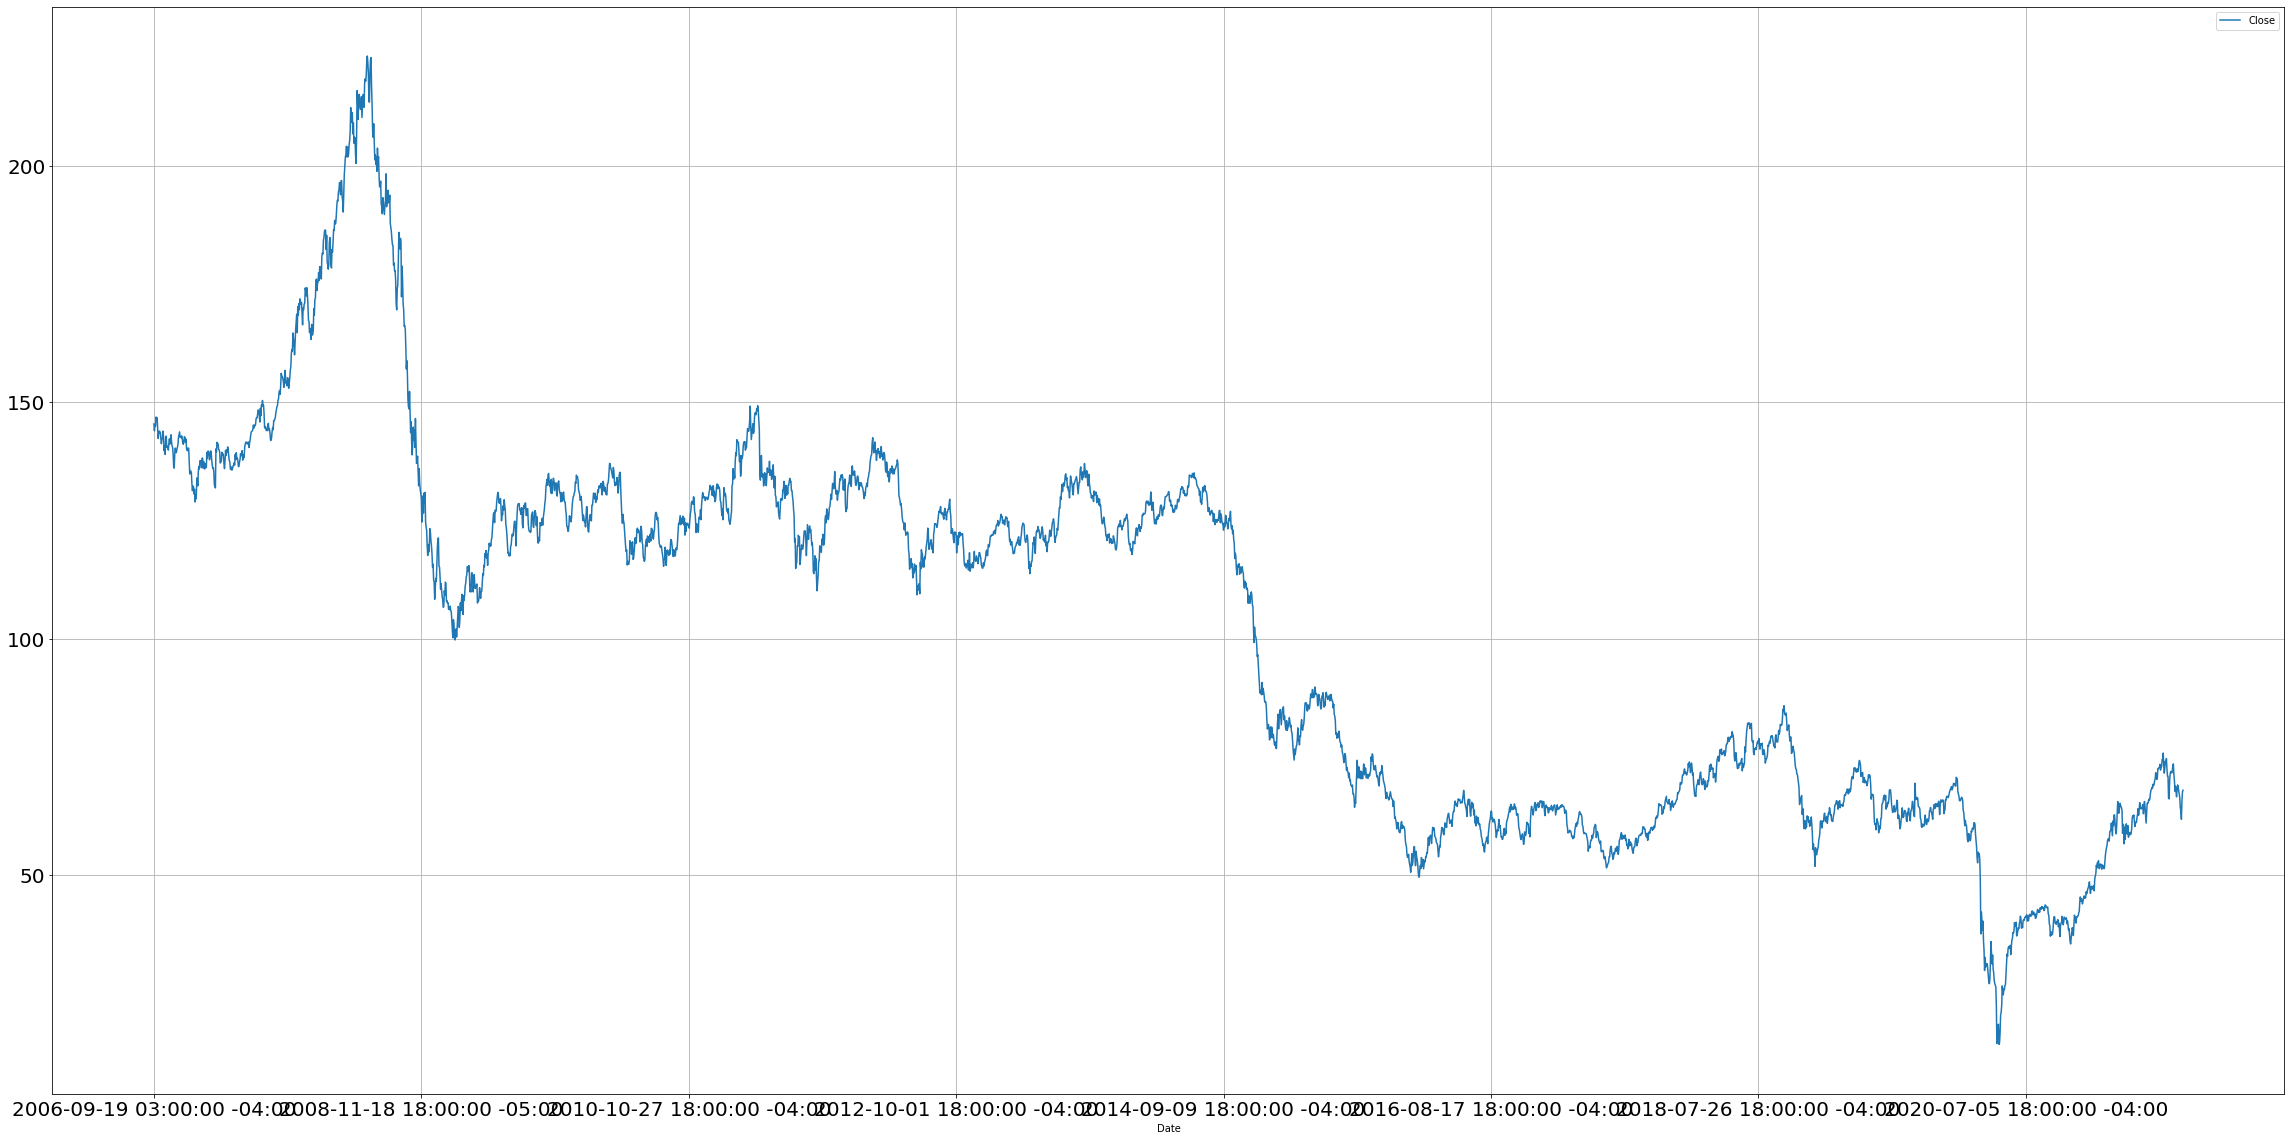

In [81]:
graph(df2, True)

In [68]:
url = 'https://firstratedata.com/datafile/E6qinKH2-EuK6XedI44HqQ/14832'
response = requests.get(url, stream=True)
handle = open('min.zip', "wb")
for chunk in response.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

zip_file = ZipFile('min.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()}

for txtfile in dfs:
    code = txtfile.split("_")[0]
    code_format = code_dict.get(code, code)
    cursor.execute("SELECT [MinuteRecordId] FROM dbo.FuturesStubs WHERE BBSymbol = ? AND TTSymbol IS NOT NULL", code_format)
    for row in cursor.fetchall():
        cursor.execute("SELECT [S3BucketName], [S3PathName], [S3FileName] FROM dbo.DataRecords WHERE Id = ?", row[0])
        for row_nest in cursor.fetchall():
            if check(row_nest[0], row_nest[1], 'FRD_'+row_nest[2]):
                df = get_s3_object2(row_nest[0], row_nest[1], 'FRD_'+row_nest[2])
                update_df = format_update(dfs.get(txtfile))
                df_return = update_data(df, update_df)
                save_s3_object(row_nest[0], row_nest[1], 'FRD_'+row_nest[2], df_return)

Saved S3 Object: lc-market-data:Futures/US/CME/AD/FRD_ADC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/CME/CD/FRD_CDC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/CME/BP/FRD_BPC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/CME/BTC/FRD_BTCC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/NYM/CL/FRD_CLC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/FNX/DX/FRD_DXC1_minute.txt
Saved S3 Object: lc-market-data:Futures/DE/EUX/GX/FRD_GXC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/CME/SF/FRD_SFC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/CME/EC/FRD_ECC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/CME/ED/FRD_EDC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/CME/ES/FRD_ESC1_minute.txt
Saved S3 Object: lc-market-data:Futures/GB/ICF/ES/FRD_ESC1_minute.txt
Saved S3 Object: lc-market-data:Futures/DE/EUX/VG/FRD_VGC1_minute.txt
Saved S3 Object: lc-market-data:Futures/US/CMX/GC/FRD_GCC1_minute.txt
Saved S3 Object: l

In [68]:
url = 'https://firstratedata.com/datafile/E6qinKH2-EuK6XedI44HqQ/14835'

In [69]:
target_path = 'hour.zip'

response = requests.get(url, stream=True)
handle = open(target_path, "wb")
for chunk in response.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

for txtfile in dfs:
    code = txtfile.split("_")[0]
    code_format = code_dict.get(code, code)
    cursor.execute("SELECT [MinuteRecordId] FROM dbo.FuturesStubs WHERE BBSymbol = ? AND TTSymbol IS NOT NULL", code_format)
    for row in cursor.fetchall():
        cursor.execute("SELECT [S3BucketName], [S3PathName], [S3FileName] FROM dbo.DataRecords WHERE Id = ?", row[0])
        for row_nest in cursor.fetchall():
            if check(row_nest[0], row_nest[1], 'FRD_'+row_nest[2]):
                df = get_s3_object2(row_nest[0], row_nest[1], 'FRD_'+row_nest[2])
                update_df = format_update(dfs.get(txtfile))
                df_return = update_data(df, update_df)
                save_s3_object(row_nest[0], row_nest[1], 'FRD_'+row_nest[2], df_return)

In [14]:
zip_file = ZipFile('hour.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()}

In [60]:
start = time.time()
for txtfile in dfs:
    code = txtfile.split("_")[0]
    code_format = code_dict.get(code, code)
    cursor.execute("SELECT [HourRecordId], [DayRecordId] FROM dbo.FuturesStubs WHERE BBSymbol = ? AND TTSymbol IS NOT NULL", code_format)
    for row in cursor.fetchall():
        cursor.execute("SELECT [S3BucketName], [S3PathName], [S3FileName] FROM dbo.DataRecords WHERE Id = ?", row[0])
        for row_nest in cursor.fetchall():
            if check(row_nest[0], row_nest[1], 'FRD_'+row_nest[2]):
                df = get_s3_object2(row_nest[0], row_nest[1], 'FRD_'+row_nest[2])
                update_df = format_update(dfs.get(txtfile))
                df_return = update_data(df, update_df)
                save_s3_object(row_nest[0], row_nest[1], 'FRD_'+row_nest[2], df_return)
                
                #cursor.execute("SELECT [S3BucketName], [S3PathName], [S3FileName] FROM dbo.DataRecords WHERE Id = ?", row[1])
                #for row_nest2 in cursor.fetchall():
                #    if cursor.rowcount != 0:
                #        save_s3_object(row_nest2[0], row_nest2[1], 'FRD_'+row_nest2[2], get_daily_bars(df_return))
end = time.time()
print(end-start)

Saved S3 Object: lc-market-data:Futures/US/CME/AD/FRD_ADC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/CME/CD/FRD_CDC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/CME/BP/FRD_BPC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/CME/BTC/FRD_BTCC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/NYM/CL/FRD_CLC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/FNX/DX/FRD_DXC1_hour.txt
Saved S3 Object: lc-market-data:Futures/DE/EUX/GX/FRD_GXC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/CME/SF/FRD_SFC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/CME/EC/FRD_ECC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/CME/ED/FRD_EDC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/CME/ES/FRD_ESC1_hour.txt
Saved S3 Object: lc-market-data:Futures/GB/ICF/ES/FRD_ESC1_hour.txt
Saved S3 Object: lc-market-data:Futures/DE/EUX/VG/FRD_VGC1_hour.txt
Saved S3 Object: lc-market-data:Futures/US/CMX/GC/FRD_GCC1_hour.txt
Saved S3 Object: lc-market-data:Futures/DE/EUX

In [87]:
df = get_s3_object('lc-market-data', 'Futures/US/NYM/NG/', 'FRD_NGC1_hour.txt')
df.head()

,Date,Open,High,Low,Close,Volume,Engine,Source,Update,Time,Offset
0,2006-10-31,21.723,21.731,21.723,21.731,11,NaN,FirstRateData,2021-08-26 11:23:20 -07:00,21:00:00,-05:00
1,2006-10-31,21.741,21.764,21.732,21.741,15,NaN,FirstRateData,2021-08-26 11:23:20 -07:00,22:00:00,-05:00
2,2006-10-31,21.740,21.740,21.740,21.740,4,NaN,FirstRateData,2021-08-26 11:23:20 -07:00,23:00:00,-05:00
3,2006-11-01,21.712,21.712,21.699,21.699,15,NaN,FirstRateData,2021-08-26 11:23:20 -07:00,00:00:00,-05:00
4,2006-11-01,21.717,21.717,21.709,21.709,13,NaN,FirstRateData,2021-08-26 11:23:20 -07:00,01:00:00,-05:00


In [ ]:
df = get_s3_object2('lc-market-data', 'Futures/US/CME/ES/', 'ESC1_hour.txt')
graph(df, True)

In [91]:
for txtfile in dfs:
    code = txtfile.split("_")[0]
    code_format = code_dict.get(code, code)
    cursor.execute("SELECT [HourRecordId], [DayRecordId] FROM dbo.FuturesStubs WHERE BBSymbol = ? AND TTSymbol IS NOT NULL", code_format)
    for row in cursor.fetchall():
        cursor.execute("SELECT [S3BucketName], [S3PathName], [S3FileName] FROM dbo.DataRecords WHERE Id = ?", row[0])
        for row_nest in cursor.fetchall():
            if check(row_nest[0], row_nest[1], 'FRD_'+row_nest[2]):
                df = get_s3_object2(row_nest[0], row_nest[1], 'FRD_'+row_nest[2])
                #update_df = format_update(dfs.get(txtfile))
                #df_return = update_data(df, update_df)
                #save_s3_object(row_nest[0], row_nest[1], 'FRD_'+row_nest[2], df_return)
                
                cursor.execute("SELECT [S3BucketName], [S3PathName], [S3FileName] FROM dbo.DataRecords WHERE Id = ?", row[1])
                for row_nest2 in cursor.fetchall():
                    if cursor.rowcount != 0:
                        save_s3_object(row_nest2[0], row_nest2[1], 'FRD_'+row_nest2[2], get_daily_bars(df))

NameError: name 'dfs' is not defined

In [27]:
cursor.execute("SELECT [HourRecordId], [DayRecordId] FROM dbo.FuturesStubs WHERE TTSymbol IS NOT NULL")
for row in cursor.fetchall():
    cursor.execute("SELECT [S3BucketName], [S3PathName], [S3FileName] FROM dbo.DataRecords WHERE Id = ?", row[0])
    for row_nest in cursor.fetchall():
        if check(row_nest[0], row_nest[1], 'FRD_'+row_nest[2]):
            df = get_s3_object2(row_nest[0], row_nest[1], 'FRD_'+row_nest[2])
            cursor.execute("SELECT [S3BucketName], [S3PathName], [S3FileName] FROM dbo.DataRecords WHERE Id = ?", row[1])
            for row_nest2 in cursor.fetchall():
                if cursor.rowcount != 0:
                    save_s3_object(row_nest2[0], row_nest2[1], 'FRD_'+row_nest2[2], get_daily_bars(df))

Saved S3 Object: lc-market-data:Futures/US/CME/ES/FRD_ESC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/CME/NQ/FRD_NQC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/CBT/DM/FRD_DMC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/CME/RTY/FRD_RTYC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/NYM/CL/FRD_CLC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/NYM/NG/FRD_NGC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/NYM/XB/FRD_XBC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/NYM/HO/FRD_HOC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/CBT/FF/FRD_FFC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/CME/ED/FRD_EDC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/CBT/TU/FRD_TUC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/CBT/TY/FRD_TYC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/CBT/US/FRD_USC1_daily.txt
Saved S3 Object: lc-market-data:Futures/US/CMX/GC/FRD_GCC1_daily.txt
Saved S3 Object: lc-market-data:

In [24]:
df = pd.read_csv('openclose.csv')
int(df.loc[0]['Open'])

FileNotFoundError: [Errno 2] No such file or directory: 'openclose.csv'

In [19]:
counter = 0
cursor.execute("SELECT [Id] FROM dbo.FuturesStubs")
for row in cursor.fetchall():
    cursor.execute("UPDATE dbo.FuturesStubs SET OpenTimeOffset = ?, CloseTimeOffset = ? WHERE Id = ?", int(df.loc[counter]['Open']), int(df.loc[counter]['Close']), row[0])
    cnxn.commit()
    counter += 1
    

In [27]:
def get_updated_daily(df, update_df):
    last_date = df.index[-1]
    df_slice = update_df[update_df.index >= last_date]
    df_slice_formatted = get_daily_bars(df_slice)
    return pd.concat([df.iloc[:-1], df_slice_formatted])

In [29]:
df = get_s3_object2('lc-market-data', 'Futures/US/NYM/CL/', 'FRD_CLC1_hour.txt')
df2 = get_s3_object2('lc-market-data', 'Futures/US/NYM/CL/', 'FRD_CLC1_daily.txt')
df3 = get_updated_daily(df2, df)
df3

AttributeError: 'DataFrame' object has no attribute 'now'

In [31]:
df = get_s3_object2('lc-market-data', 'Futures/US/NYM/CL/', 'FRD_CLC1_hour.txt')
df2 = get_s3_object2('lc-market-data', 'Futures/US/NYM/CL/', 'FRD_CLC1_daily.txt')

last_date = df2.index[-1]
df_slice = df[df.index >= last_date]
df_slice_formatted = get_daily_bars(df_slice)
df3 = pd.concat([df2.iloc[:-1], df_slice_formatted])
df3

,Open,High,Low,Close,Volume,Engine,Source,Update
Date,,,,,,,,
2006-09-19 03:00:00 -04:00,147.64,148.26,145.35,145.41,15362,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2006-09-19 18:00:00 -04:00,145.50,145.63,143.85,143.95,5353,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2006-09-24 18:00:00 -04:00,144.05,145.95,143.32,145.21,63039,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2006-09-25 18:00:00 -04:00,145.24,145.79,144.40,144.93,63484,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2006-09-26 18:00:00 -04:00,144.94,146.90,143.90,146.87,75144,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
...,...,...,...,...,...,...,...,...
2021-08-19 18:00:00 -04:00,63.65,64.04,61.82,61.86,284692,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2021-08-22 18:00:00 -04:00,61.96,66.00,61.74,65.54,313968,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2021-08-23 18:00:00 -04:00,65.54,67.80,65.41,67.64,264800,Internal,FirstRateData,2021-08-27 17:57:40 -07:00


In [19]:
df2 = get_s3_object2('lc-market-data', 'Futures/US/NYM/CL/', 'FRD_CLC1_daily.txt')

,Open,High,Low,Close,Volume,Engine,Source,Update
Date,,,,,,,,
2006-09-19 03:00:00 -04:00,147.64,148.26,145.35,145.41,15362,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2006-09-19 18:00:00 -04:00,145.50,145.63,143.85,143.95,5353,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2006-09-24 18:00:00 -04:00,144.05,145.95,143.32,145.21,63039,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2006-09-25 18:00:00 -04:00,145.24,145.79,144.40,144.93,63484,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2006-09-26 18:00:00 -04:00,144.94,146.90,143.90,146.87,75144,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
...,...,...,...,...,...,...,...,...
2021-08-18 18:00:00 -04:00,64.45,64.57,62.41,63.69,384098,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2021-08-19 18:00:00 -04:00,63.65,64.04,61.82,61.86,284692,Internal,FirstRateData,2021-08-27 17:57:40 -07:00
2021-08-22 18:00:00 -04:00,61.96,66.00,61.74,65.54,313968,Internal,FirstRateData,2021-08-27 17:57:40 -07:00


In [21]:
last_date = df2.index[-1]
df_slice = df[df.index >= last_date]
df_slice_formatted = 

,Open,High,Low,Close,Volume,Engine,Source,Update
Date,,,,,,,,
2021-08-24 18:00:00 -04:00,67.63,67.66,67.56,67.59,1486,NaN,FirstRateData,2021-08-26 16:08:52 -07:00
2021-08-24 19:00:00 -04:00,67.59,67.59,67.35,67.43,1836,NaN,FirstRateData,2021-08-26 16:08:52 -07:00
2021-08-24 20:00:00 -04:00,67.43,67.62,67.36,67.42,3356,NaN,FirstRateData,2021-08-26 16:08:52 -07:00
2021-08-24 21:00:00 -04:00,67.42,67.48,67.25,67.30,4530,NaN,FirstRateData,2021-08-26 16:08:52 -07:00
2021-08-24 22:00:00 -04:00,67.31,67.31,67.04,67.06,6166,NaN,FirstRateData,2021-08-26 16:08:52 -07:00
2021-08-24 23:00:00 -04:00,67.06,67.18,67.01,67.18,2786,NaN,FirstRateData,2021-08-26 16:08:52 -07:00
2021-08-25 00:00:00 -04:00,67.17,67.21,67.09,67.14,1338,NaN,FirstRateData,2021-08-26 16:08:52 -07:00
2021-08-25 01:00:00 -04:00,67.13,67.41,67.12,67.31,3747,NaN,FirstRateData,2021-08-26 16:08:52 -07:00
2021-08-25 02:00:00 -04:00,67.31,67.49,67.28,67.47,4899,NaN,FirstRateData,2021-08-26 16:08:52 -07:00


In [23]:
df10 = get_daily_bars(df_slice)
df10

,Open,High,Low,Close,Volume,Engine,Source,Update
Date,,,,,,,,
2021-08-24 18:00:00 -04:00,67.63,68.54,66.92,67.99,277590,Internal,FirstRateData,2021-08-30 15:03:55 -07:00
2021-08-25 18:00:00 -04:00,68.00,68.31,67.02,67.78,270180,Internal,FirstRateData,2021-08-30 15:03:55 -07:00


In [24]:
df10.iloc[:-1]

,Open,High,Low,Close,Volume,Engine,Source,Update
Date,,,,,,,,
2021-08-24 18:00:00 -04:00,67.63,68.54,66.92,67.99,277590,Internal,FirstRateData,2021-08-30 15:03:55 -07:00
